# Histogram of cloud ice at various levels relative to the cold point


### One region at a time

In [1]:
import dask
import pickle
import sys
sys.path.append("/home/b/b380887/cold-point-overshoot/python_scripts")

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import get_d2_data as get_d2
import tol_colors as tc

from matplotlib.gridspec import GridSpec
from dask.diagnostics import ProgressBar


In [2]:
file_path = "/work/bb1153/b380887/10x10/"
global_tropics_dir = "/work/bb1153/b380887/global_tropics/"
save_dir = "/home/b/b380887/cold-point-overshoot/plots/d2_paper_poster/cirrus_hists/"
pickle_dir = "/home/b/b380887/cold-point-overshoot/pickle_files/d2_cirrus_hists/"
cp_inds_dir = "/work/bb1153/b380887/10x10/cp_inds/"
dar_path = global_tropics_dir + "obs/DARDAR/"


In [3]:
region = "SPC"
region = "AMZ"

model_list = ["OBS", "GEOS", "SHIELD", "ICON", "SAM", "SCREAM"]


In [4]:
start_date = "2020-01-30"
end_date = "2020-03-01"

In [5]:
qi_min = 1e-6

In [6]:
# for DARDAR

year_list = [2007, 2008, 2009, 2010]

if region == "SPC":
    ln0, ln1, lt0, lt1 = 170, 180, -15, -5
elif region == "AMZ": 
    ln0, ln1, lt0, lt1 = -65, -55, -30, -20
    
# # try the big regions?
# if region == "SPC": 
#     ln0, ln1, lt0, lt1 = 165, -145, -20, -5
# elif region == "AMZ":
#     ln0, ln1, lt0, lt1 = -72, -47, -30, 0


### Get cold point-relative cloud ice

Note that `get_d2` returned reindexed (bottom-->up) qi, so you don't have to do that again!

In [7]:
qi_dict = {}

In [8]:
%%time

for model in model_list:
# for model in ["OBS"]:
    if model == "OBS":
        dar = get_d2.get_cp_relative_dardar("ITCZ", "Feb", dar_path, year_list, qi_min=0, unique_times=True)
        dar_no_min = get_d2.get_cp_relative_dardar("ITCZ", "Feb", dar_path, year_list, qi_min=None, unique_times=True)["qi_cp"]
        # subset the 10x10 region (this is fast)
        if ln1 < ln0:
            qi1 = dar.where(dar.lon >= ln0, drop=True).where(dar.lon < 180, drop=True).where(dar.lat >= lt0).where(dar.lat < lt1)
            qi2 = dar.where(dar.lon <= ln1, drop=True).where(dar.lon > -180, drop=True).where(dar.lat >= lt0).where(dar.lat < lt1)
            qi = xr.concat([qi1, qi2], dim="time")
            no_min_1 = dar_no_min.where(dar_no_min.lon >= ln0, drop=True) \
                                     .where(dar_no_min.lon < 180, drop=True) \
                                     .where(dar_no_min.lat >= lt0, drop=True) \
                                     .where(dar_no_min.lat < lt1, drop=True)
            no_min_2 = dar_no_min.where(dar_no_min.lon <= ln1, drop=True) \
                                     .where(dar_no_min.lon > -180, drop=True) \
                                     .where(dar_no_min.lat >= lt0, drop=True) \
                                     .where(dar_no_min.lat < lt1, drop=True) 
            n_retrievals = xr.concat([no_min_1, no_min_2], dim="time").count(dim="time").values
        else:
            qi = dar.where(dar.lon >= ln0, drop=True).where(dar.lon < ln1, drop=True).where(dar.lat >= lt0).where(dar.lat < lt1)
            n_retrievals = dar_no_min.where(dar_no_min.lon >= ln0, drop=True) \
                                     .where(dar_no_min.lon < ln1, drop=True) \
                                     .where(dar_no_min.lat >= lt0, drop=True) \
                                     .where(dar_no_min.lat < lt1, drop=True).count(dim="time").values
        qi_cp = qi["qi_cp"]
        qi_a500 = qi["qi_a500"]
        qi_a1000 = qi["qi_a1000"]
        qi_b500 = qi["qi_b500"]
        qi_b1000 = qi["qi_b1000"]
        
        # compare to len(qi.time) and was 4x mean 5x5 count
        n_retrievals_obs = n_retrievals
        print(n_retrievals_obs, len(qi.time), 18944*4)

        
    else:
        cp_inds = xr.open_dataset(cp_inds_dir + "{m}_cp_inds_{r}.nc".format(r=region, m=model))["cp_inds_cut"].astype(int)
        if model == "SCREAM":
            # actually is qtot
            qi = get_d2.get_qtot(region, model, file_path, qi_min=0)
            cp_inds = cp_inds.rename({"grid_size": "ncol"})
        else:
            qi = get_d2.get_qi(region, model, file_path, qi_min=0)
            
        if model == "SAM": 
            # get the lats to match (truncation issue with the final decimal?)
            cp_inds = cp_inds.assign_coords({"lat": qi.lat})
            qi_cp = qi.isel(z=cp_inds)
            qi_a500 = qi.isel(z=cp_inds+1)
            qi_b500 = qi.isel(z=cp_inds-1)
            qi_a1000 = qi.isel(z=cp_inds+2)
            qi_b1000 = qi.isel(z=cp_inds-2)

        elif model == "ICON":
            qi_cp = qi.isel(height=cp_inds)
            qi_a500 = qi.isel(height=cp_inds+1)
            qi_b500 = qi.isel(height=cp_inds-1)
            qi_a1000 = qi.isel(height=cp_inds+2)
            qi_b1000 = qi.isel(height=cp_inds-2)

        elif model == "SHIELD":
            cp_inds = cp_inds.sel(time=qi.time)
            qi_cp = qi.isel(pfull_ref=cp_inds)
            qi_a500 = qi.isel(pfull_ref=cp_inds+1)
            qi_b500 = qi.isel(pfull_ref=cp_inds-1)
            qi_a1000 = qi.isel(pfull_ref=cp_inds+2)
            qi_b1000 = qi.isel(pfull_ref=cp_inds-2)

        elif model == "SCREAM" or model == "GEOS":
            qi_cp = qi.isel(lev=cp_inds)
            qi_a500 = qi.isel(lev=cp_inds+2)
            qi_b500 = qi.isel(lev=cp_inds-2)
            qi_a1000 = qi.isel(lev=cp_inds+4)
            qi_b1000 = qi.isel(lev=cp_inds-4)
        
    model_dict = {
        "qi_b1000": qi_b1000,
        "qi_b500": qi_b500,
        "qi_cp": qi_cp,
        "qi_a500": qi_a500,
        "qi_a1000": qi_a1000
    }
    
    qi_dict[model] = model_dict
    print(model, "done")



DIVIDING by reference density to go from kg/m3 to kg/kg
DIVIDING by reference density to go from kg/m3 to kg/kg
DIVIDING by reference density to go from kg/m3 to kg/kg
DIVIDING by reference density to go from kg/m3 to kg/kg
DIVIDING by reference density to go from kg/m3 to kg/kg
DIVIDING by reference density to go from kg/m3 to kg/kg
DIVIDING by reference density to go from kg/m3 to kg/kg
DIVIDING by reference density to go from kg/m3 to kg/kg
79838 310569 75776
OBS done
GEOS done
SHIELD done
ICON done
SAM done
SCREAM done
CPU times: user 27.8 s, sys: 29.7 s, total: 57.5 s
Wall time: 2min 53s


In [9]:
# SPC:
print(qi_dict["OBS"]["qi_b1000"].max().values)
print(qi_dict["SHIELD"]["qi_b1000"].max().values)


0.005506551
0.005801392


In [27]:
# SPC_big:
print(qi_dict["OBS"]["qi_b1000"].max().values)
print(qi_dict["SHIELD"]["qi_b1000"].max().values)


<xarray.DataArray 'qi_a1000' ()>
array(1.1418199e-06, dtype=float32)

In [10]:
# AMZ:
print(qi_dict["OBS"]["qi_b1000"].max().values)
print(qi_dict["SCREAM"]["qi_b1000"].max().values)


0.015696265
0.01965515


In [9]:
# AMZ:
print(qi_dict["OBS"]["qi_b1000"].max().values)
print(qi_dict["SCREAM"]["qi_b1000"].max().values)


0.015696265
0.01965515


In [9]:
# AMZ_big:
print(qi_dict["OBS"]["qi_b1000"].max().values)
print(qi_dict["SHIELD"]["qi_b1000"].max().values)


<xarray.DataArray 'qi_a1000' ()>
array(2.660123e-06, dtype=float32)

### Plot

In [10]:
title_dict = {
    "SAM": "gSAM",
    "SHIELD": "X-SHiELD",
    "ICON": "ICON",
    "GEOS": "GEOS", 
    "SCREAM": "SCREAM",
    "OBS": "Obs. (Feb. 2007-2010)"
}

In [11]:
def mask_qi_below(qi, qi_min=1e-6):
    """ Helper function to mask out "zero" values before plotting
    """
    return qi.where(qi > qi_min)


In [12]:
def mask_qi_above(qi, qi_max):
    """ Helper function to mask out larger values before plotting
    """
    return qi.where(qi < qi_max)


In [13]:
def plot_qi_hist(qi_dict, model_list, region, title_dict, n_retrievals=None, lw=2, rad_min=2e-6, qi_bins=None, save=False,
                 qi_min=1e-6, fsize=14, tsize=18, labsize=12, figsize=(18, 8), ylim=(0, 0.01),
                annotate_fracs=True, mask_min=False, xmax=1e-2, upper_lim=None):
    """ Plot histogram of qi at one level
    """
    # colors = plt.cm.turbo(np.arange(5)/5)
    colors = tc.tol_cmap("rainbow_PuBr")(np.arange(5)/5) # more colorblind-friendly, easier to read

    if qi_bins is None:
        qi_bins = 10**np.arange(np.log10(rad_min), -2+.1, 0.1)
        # qi_bins = 10**np.arange(np.log10(qi_min), -2+.1, 0.1)
    
    # set up the gridspec...
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(3, 3, height_ratios=[0.075, 1, 1], hspace=0.6, wspace=0.4)
    ax_list = [
        plt.subplot(gs[1, 0]),
        plt.subplot(gs[1, 1]),
        plt.subplot(gs[1, 2]),
        plt.subplot(gs[2, 0]),
        plt.subplot(gs[2, 1]),
        plt.subplot(gs[2, 2]),
    ]
    ax_title = plt.subplot(gs[0, :])
    
    for i, model in enumerate(model_list):
        ax = ax_list[i] 
        ax.grid(linestyle=":", color="gray")
        
        qi_b1000 = qi_dict[model]["qi_b1000"]
        qi_b500 = qi_dict[model]["qi_b500"]
        qi_cp = qi_dict[model]["qi_cp"]
        qi_a500 = qi_dict[model]["qi_a500"]
        qi_a1000 = qi_dict[model]["qi_a1000"]
        
        if mask_min:
            qi_b1000 = mask_qi_below(qi_b1000, rad_min)
            qi_b500 = mask_qi_below(qi_b500, rad_min)
            qi_cp = mask_qi_below(qi_cp, rad_min)
            qi_a500 = mask_qi_below(qi_a500, rad_min)
            qi_a1000 = mask_qi_below(qi_a1000, rad_min)
        if upper_lim is not None:
            qi_b1000 = mask_qi_above(qi_b1000, upper_lim)
            qi_b500 = mask_qi_above(qi_b500, upper_lim)
            qi_cp = mask_qi_above(qi_cp, upper_lim)
            qi_a500 = mask_qi_above(qi_a500, upper_lim)
            qi_a1000 = mask_qi_above(qi_a1000, upper_lim)

        # weigh it out of ALL points [time, lat, lon] (not just qi > 1e-6) so you can 
        # get a sense of the cloud fraction
        n_pts = qi_cp.size
        if model == "OBS" and n_retrievals is not None:
            weights = np.ones(n_pts) / float(n_retrievals)
        else:
            weights = np.ones(n_pts) / float(n_pts)
    
        freq_b1000, _, _ = ax.hist(qi_b1000.values.flatten(), bins=qi_bins, weights=weights, histtype="step",
                                  color=colors[0], linewidth=lw)
        freq_b500, _, _ = ax.hist(qi_b500.values.flatten(), bins=qi_bins, weights=weights, histtype="step",
                                  color=colors[1], linewidth=lw)
        freq_cp, _, _ = ax.hist(qi_cp.values.flatten(), bins=qi_bins, weights=weights, histtype="step", 
                                color=colors[2], linewidth=lw+1) # new - thicker line at the cold point level
        freq_a500, _, _ = ax.hist(qi_a500.values.flatten(), bins=qi_bins, weights=weights, histtype="step",
                                  color=colors[3], linewidth=lw)
        freq_a1000, _, _ = ax.hist(qi_a1000.values.flatten(), bins=qi_bins, weights=weights, histtype="step",
                                  color=colors[4], linewidth=lw)

        ax.set_xscale("log")
        if i in [0, 3]:
            ax.set_ylabel("Fraction", fontsize=fsize)
        if i in [3, 4, 5]:
            ax.set_xlabel("Cloud ice (kg/kg)", fontsize=fsize)

        ax.set_title(title_dict[model], fontsize=tsize)
        ax.set_xlim(left=rad_min, right=xmax)
        ax.set_ylim(ylim)
        ax.tick_params(axis="both", labelsize=labsize)
    
        if annotate_fracs:
            ax.annotate("{p:.2f}%".format(p=freq_b1000.sum()*100.), xy=(0.7, 0.45),
                        xycoords="axes fraction", color=colors[0], fontsize=fsize)
            ax.annotate("{p:.2f}%".format(p=freq_b500.sum()*100.), xy=(0.7, 0.55),
                        xycoords="axes fraction", color=colors[1], fontsize=fsize)
            ax.annotate("{p:.2f}%".format(p=freq_cp.sum()*100.), xy=(0.7, 0.65),
                        xycoords="axes fraction", color=colors[2], fontsize=fsize)
            ax.annotate("{p:.2f}%".format(p=freq_a500.sum()*100.), xy=(0.7, 0.75),
                        xycoords="axes fraction", color=colors[3], fontsize=fsize)
            ax.annotate("{p:.2f}%".format(p=freq_a1000.sum()*100.), xy=(0.7, 0.85),
                        xycoords="axes fraction", color=colors[4], fontsize=fsize)
        
    # title
    ax_title.axis("off")
    ax_title.text(x=0.5, y=0, s=region, verticalalignment="center",
                  horizontalalignment="center", fontsize=tsize+5
                  )
    
    if save:
        if annotate_fracs:
            frac = "_with_fractions"
        else:
            frac = ""
        inits = ""
        for model in model_list:
            inits += model[0]
            
        plt.savefig(save_dir + "{i}_cold_point_cirrus_hists{f}_{r}.png".format(i=inits, f=frac, r=region), 
                    dpi=300, bbox_inches="tight")
    
    plt.show()
         

In [14]:
plot_model_list = ["OBS", "ICON", "GEOS", "SAM", "SCREAM", "SHIELD"]


In [15]:
labsize = 16
tsize = 22
fsize = 20
ylim = (0, 0.04)
figsize = (18, 10)


#### AMZ

##### 10x10 obs

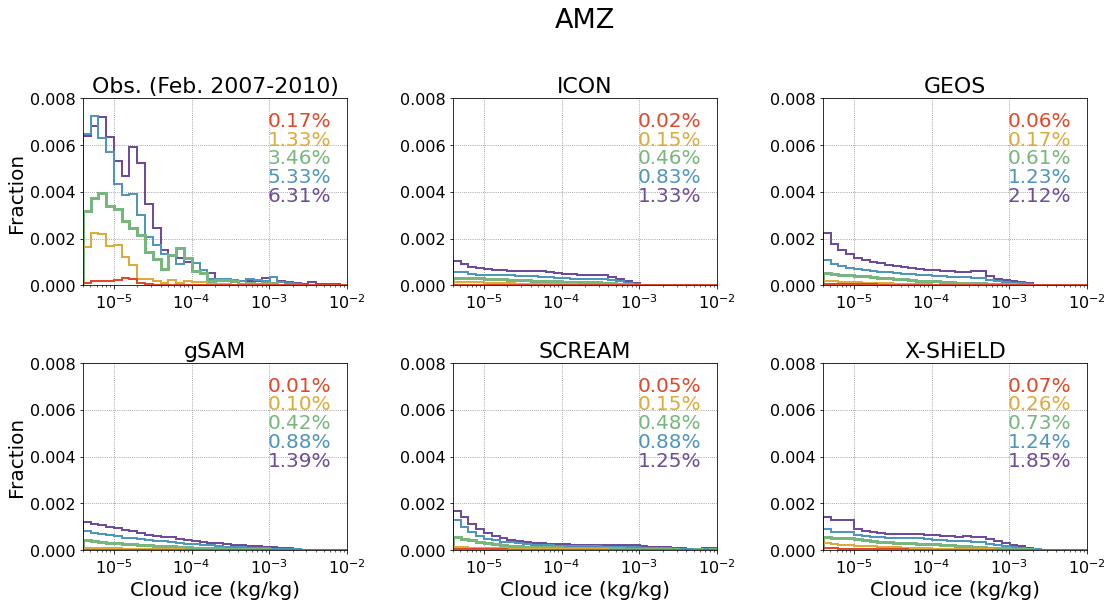

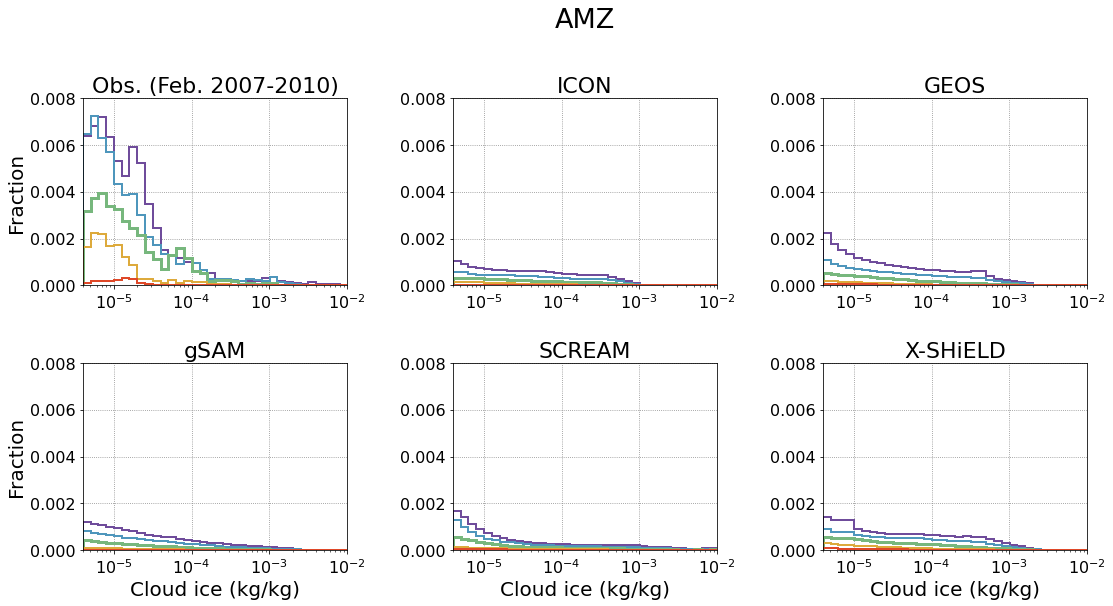

In [16]:
plot_qi_hist(qi_dict, plot_model_list, region, title_dict, n_retrievals=n_retrievals_obs,
             ylim=(0, 0.008), fsize=fsize, tsize=tsize, labsize=labsize,
             figsize=figsize, save=True, rad_min=4e-6)
plot_qi_hist(qi_dict, plot_model_list, region, title_dict, n_retrievals=n_retrievals_obs,
             ylim=(0, 0.008), fsize=fsize, tsize=tsize, labsize=labsize,
             figsize=figsize, save=True, annotate_fracs=False, rad_min=4e-6)


#### SPC

##### 10x10 obs

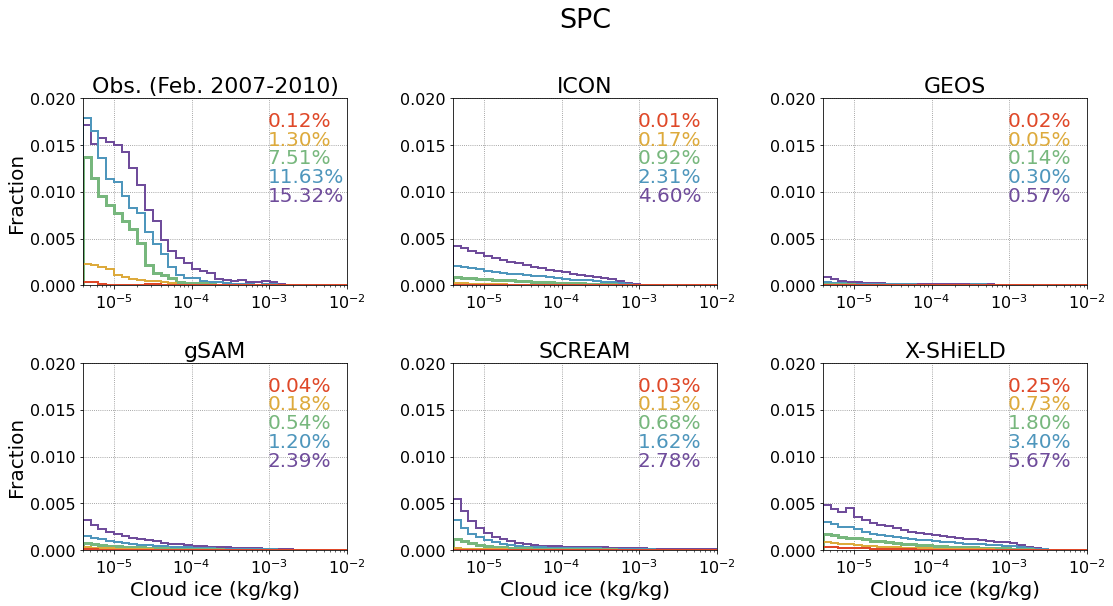

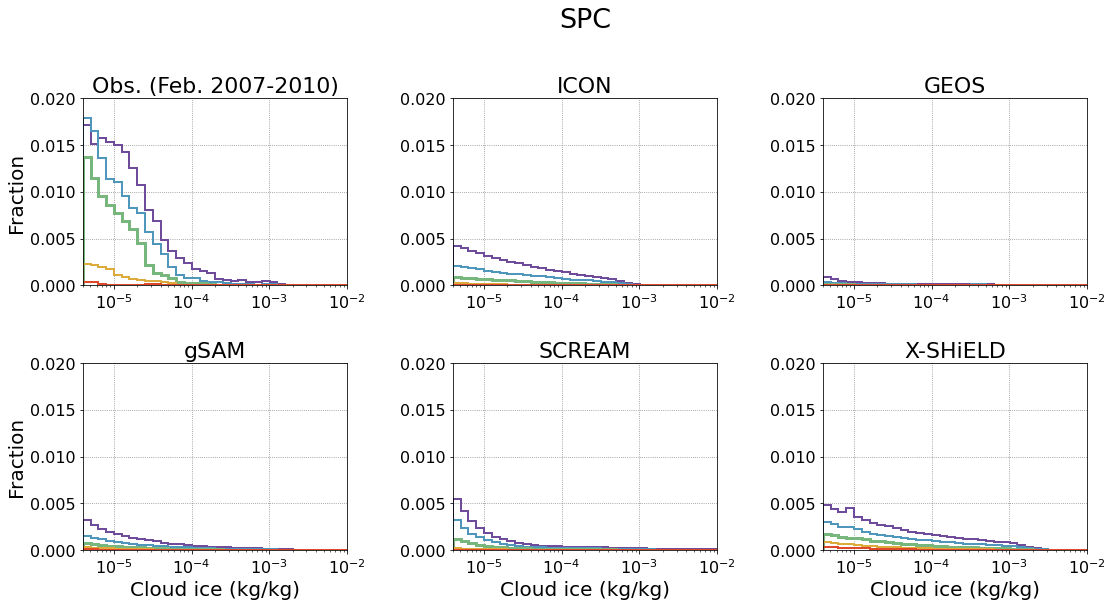

In [16]:
plot_qi_hist(qi_dict, plot_model_list, region, title_dict, n_retrievals=n_retrievals_obs,
             ylim=(0, 0.02), fsize=fsize, tsize=tsize, labsize=labsize,
             figsize=figsize, save=True, rad_min=4e-6)
plot_qi_hist(qi_dict, plot_model_list, region, title_dict, n_retrievals=n_retrievals_obs,
             ylim=(0, 0.02), fsize=fsize, tsize=tsize, labsize=labsize,
             figsize=figsize, save=True, annotate_fracs=False, rad_min=4e-6)
